<a href="https://colab.research.google.com/github/opbru/Ai-project/blob/main/AI_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"obu127","key":"97848b7be24e2505d20e724e834fc878"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import os
os.chdir('/content')
import glob
from PIL import Image
os.mkdir('flower')
os.chdir('/content/flower')
# jpg_files = glob.glob('*.jpeg')
# count = 0
# for jpg_file in jpg_files:
#     if count < 10:
#         image = Image.open(jpg_file)
#         image.show()
#         count += 1
#     else:
#         break

In [ ]:
!kaggle datasets download -d l3llff/flowers

 99% 226M/228M [00:03<00:00, 67.0MB/s]
100% 228M/228M [00:03<00:00, 67.1MB/s]


In [ ]:
! unzip flowers.zip -d flower

串流輸出內容已截斷至最後 5000 行。
  inflating: flower/flowers/magnolia/2090666304_0ff8463c5f_c.jpg  
  inflating: flower/flowers/magnolia/20914736071_ede33a230a_c.jpg  
  inflating: flower/flowers/magnolia/2126107417_92101f8b5f_c.jpg  
  inflating: flower/flowers/magnolia/21500695820_bc9f753d79_c.jpg  
  inflating: flower/flowers/magnolia/21986337916_36d1c95e64_c.jpg  
  inflating: flower/flowers/magnolia/2294580412_50846f9130_c.jpg  
  inflating: flower/flowers/magnolia/2300805045_982fa1bdf2_c.jpg  
  inflating: flower/flowers/magnolia/2306786428_99f92b0d9c_c.jpg  
  inflating: flower/flowers/magnolia/2324281515_c0269d5963_c.jpg  
  inflating: flower/flowers/magnolia/2325102200_1cb9d8cabc_c.jpg  
  inflating: flower/flowers/magnolia/2325102996_5f1e3bf13a_c.jpg  
  inflating: flower/flowers/magnolia/2325370643_f452e88ace_c.jpg  
  inflating: flower/flowers/magnolia/2334886646_c4c8ee532e_c.jpg  
  inflating: flower/flowers/magnolia/23422365843_3b4b928a4a_c.jpg  
  inflating: flower/flowers/magnolia/

In [ ]:
# imports and globals

import tensorflow as tf
from tensorflow import keras
K = keras.backend

import numpy as np
import matplotlib.pyplot as plt
import random

BATCH_SIZE = 32

IMG_WIDTH  = 96
IMG_HEIGHT = 96

ENCODING_SIZE = 8

In [ ]:
# create a flower with labels generator
flower_generator = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/flower/flower/flowers",
  seed = 84,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = BATCH_SIZE,
  labels = 'inferred'
)

# keep the flower names for future reference
flower_names = flower_generator.class_names

# create a training data generator
training_generator = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/flower/flower/flowers",
  seed = 42,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = BATCH_SIZE,
  labels = None,
  validation_split = 0.2,
  subset = 'training'
)

# and a validation set generator
validation_generator = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/flower/flower/flowers",
  seed = 42,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = BATCH_SIZE,
  labels = None,
  validation_split = 0.2,
  subset = 'validation'
)

# autoencoders require the input matrix as both the input
# and the output
# provide input -> input for the autoencoder
# and, do scaling
def replicate_inputs_to_outputs(images):
  return images/255, images/255

# create prefetch generators to speed things up a bit
training_generator = training_generator.prefetch(128)
validation_generator = validation_generator.prefetch(128)

# create the final generators to be used in training the autoencoders
X_train = training_generator.map(replicate_inputs_to_outputs)
X_valid = validation_generator.map(replicate_inputs_to_outputs)

Found 15740 files belonging to 16 classes.
Found 15740 files belonging to 1 classes.
Using 12592 files for training.
Found 15740 files belonging to 1 classes.
Using 3148 files for validation.


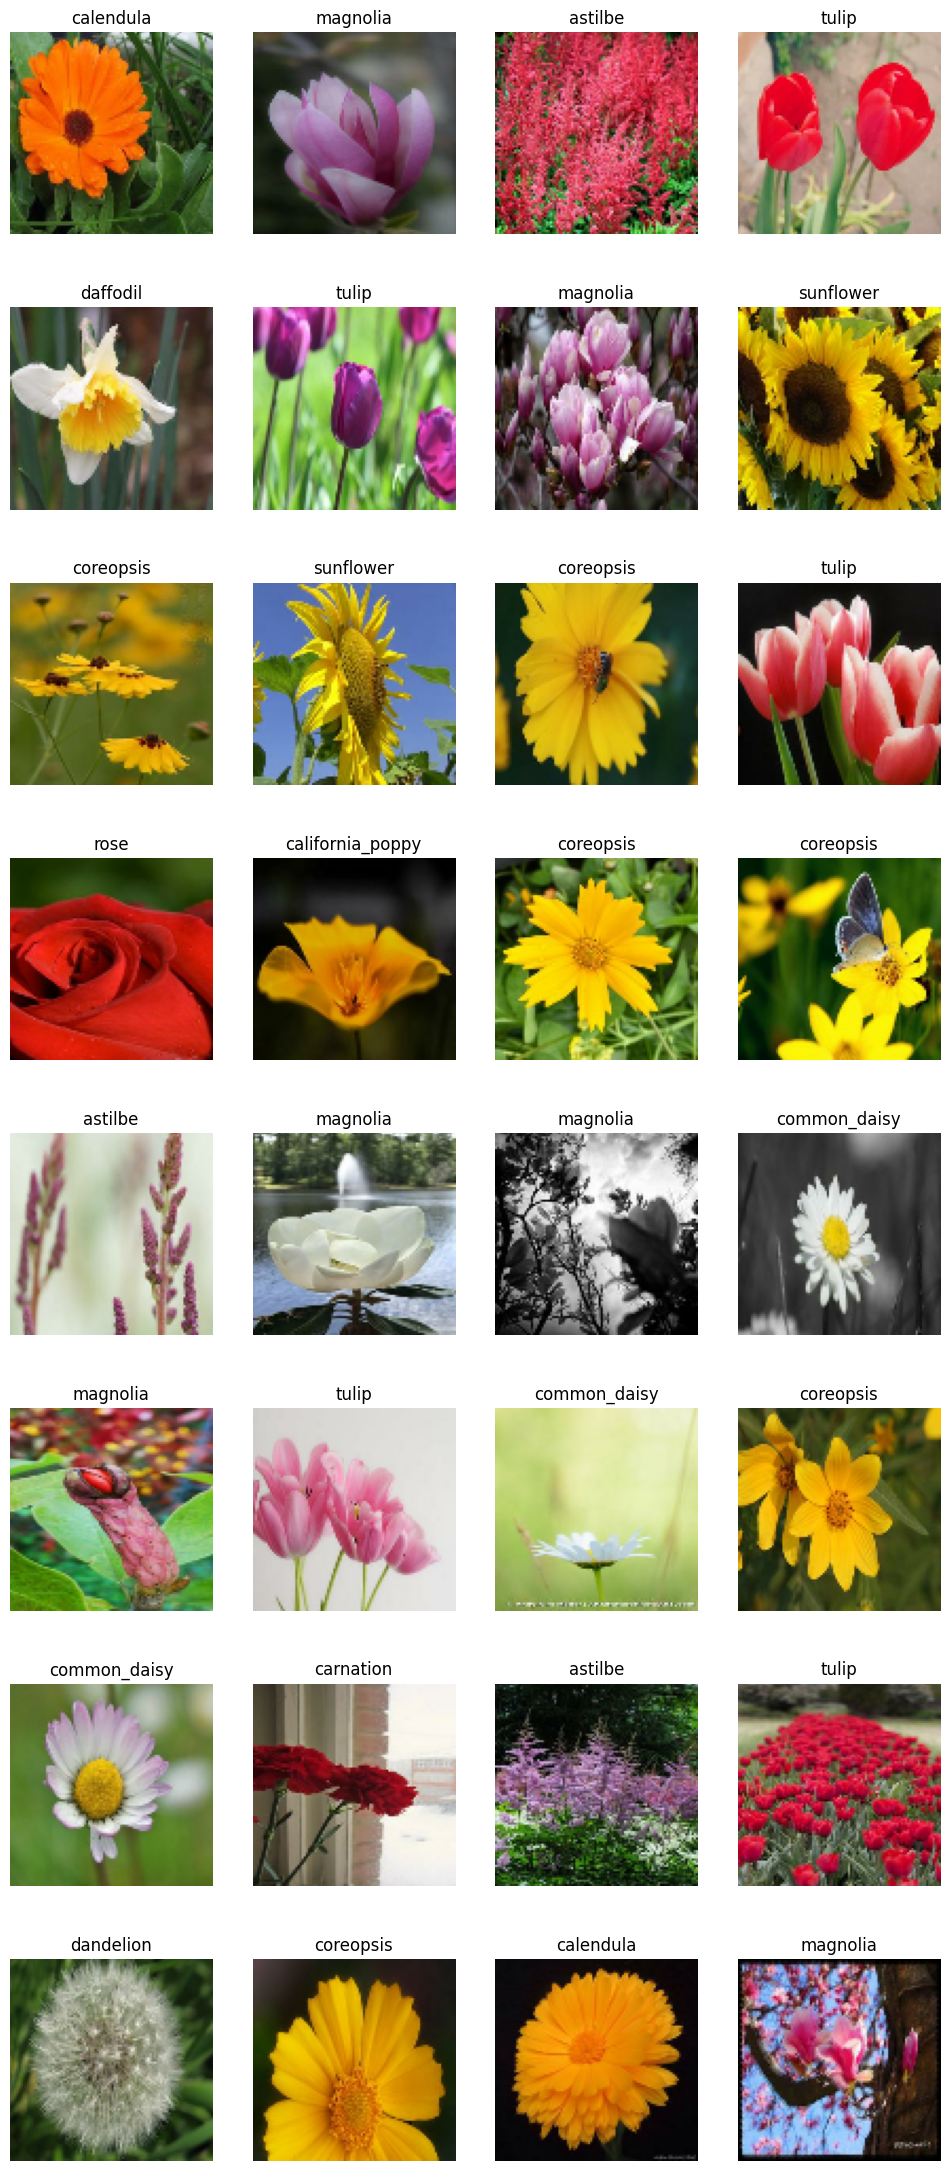

In [ ]:
# visualize a few random flowers
plt.figure(figsize=(12, 28))

for images, labels in flower_generator.take(1):
  for i in range(len(images)):
      ax = plt.subplot(8, 4, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(flower_names[labels[i]])
      plt.axis("off")

In [ ]:
ENCODING_SIZE = 8

# build a VAE based on AE structure
class Sampling(keras.layers.Layer):
  def call(self, inputs):
    mean, log_var = inputs
    return K.random_normal(tf.shape(log_var)) * K.exp(log_var /2) + mean

inputs = keras.layers.Input(shape = [IMG_WIDTH, IMG_HEIGHT, 3])
z = keras.layers.Conv2D(64, input_shape = [IMG_WIDTH, IMG_HEIGHT, 3], kernel_size = 3,
                        strides = 1, padding = 'same', activation = 'selu',
                        kernel_initializer='lecun_normal')(inputs)
z = keras.layers.Conv2D(128, kernel_size = 3, strides = 2,
                        padding = 'same', activation = 'selu',
                        kernel_initializer='lecun_normal')(z)
z = keras.layers.Conv2D(256, kernel_size = 3, strides = 2,
                        padding = 'same', activation = 'selu',
                        kernel_initializer='lecun_normal')(z)
z = keras.layers.Conv2D(512, kernel_size = 3, strides = 2,
                        padding = 'same', activation = 'selu',
                        kernel_initializer='lecun_normal')(z)
z = keras.layers.Flatten()(z)
codings_mean = keras.layers.Dense(ENCODING_SIZE)(z)
codings_log_var = keras.layers.Dense(ENCODING_SIZE)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.Model(inputs = [inputs], outputs = [codings_mean, codings_log_var, codings])

variational_encoder.summary()

decoder_inputs = keras.layers.Input(shape = [ENCODING_SIZE])
x = keras.layers.Dense(512 * 12 * 12, activation = "selu", input_shape = [ENCODING_SIZE])(decoder_inputs)
x = keras.layers.Reshape([12, 12, 512])(x)
x = keras.layers.Conv2DTranspose(filters = 512, kernel_size = 3, strides = 1,
                                 padding = "same", activation = "selu")(x)
x = keras.layers.Conv2DTranspose(filters = 256, kernel_size = 3, strides = 2,
                                 padding = "same", activation = "selu")(x)
x = keras.layers.Conv2DTranspose(filters = 128, kernel_size = 3, strides = 2,
                                 padding = "same", activation = "selu")(x)
x = keras.layers.Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2,
                                 padding = "same", activation = "selu")(x)
outputs = keras.layers.Conv2DTranspose(filters = 3, kernel_size = 3, strides = 1,
                                       padding = 'same', activation = 'sigmoid')(x)
variational_decoder = keras.Model(inputs = [decoder_inputs], outputs = [outputs])

variational_decoder.summary()

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
vae = keras.Model(inputs = [inputs], outputs = [reconstructions])

vae.summary()

# add a loss function
latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
                           axis = -1)
vae.add_loss(K.mean(latent_loss) / 31480.)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 96, 96, 64)           1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 48, 48, 128)          73856     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 24, 24, 256)          295168    ['conv2d_1[0][0]']            
                                                                                              

In [ ]:
# add learning rate scheduling
def exponential_decay_fn(epoch):
  return 0.0001 * 0.1 ** (epoch / 10)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

# add early stopping
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)

# clear the session for a clean run
keras.backend.clear_session()
tf.random.set_seed(42)

vae.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Nadam())
history = vae.fit(X_train, validation_data = X_valid,  epochs = 10, \
                  callbacks = [lr_scheduler, early_stopping_cb])

Epoch 1/10
394/394 [==============================] - 77s 179ms/step - loss: 0.0433 - val_loss: 0.0370 - lr: 1.0000e-04
Epoch 2/10
394/394 [==============================] - 75s 190ms/step - loss: 0.0364 - val_loss: 0.0365 - lr: 7.9433e-05
Epoch 3/10
394/394 [==============================] - 70s 177ms/step - loss: 0.0351 - val_loss: 0.0355 - lr: 6.3096e-05
Epoch 4/10
394/394 [==============================] - 71s 179ms/step - loss: 0.0345 - val_loss: 0.0350 - lr: 5.0119e-05
Epoch 5/10
394/394 [==============================] - 75s 189ms/step - loss: 0.0341 - val_loss: 0.0346 - lr: 3.9811e-05
Epoch 6/10
394/394 [==============================] - 70s 177ms/step - loss: 0.0339 - val_loss: 0.0345 - lr: 3.1623e-05
Epoch 7/10
394/394 [==============================] - 70s 177ms/step - loss: 0.0337 - val_loss: 0.0345 - lr: 2.5119e-05
Epoch 8/10
394/394 [==============================] - 70s 177ms/step - loss: 0.0336 - val_loss: 0.0343 - lr: 1.9953e-05
Epoch 9/10
394/394 [====================

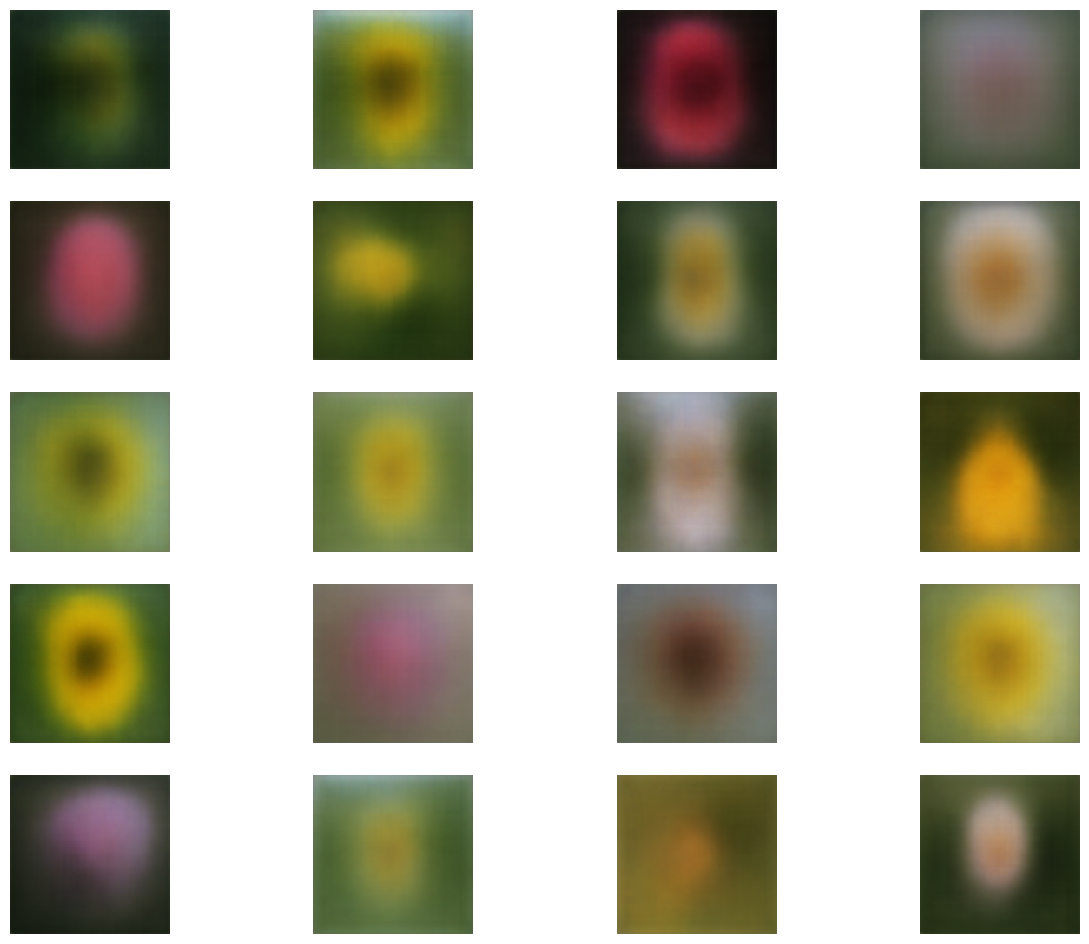

In [ ]:
# visualize a few simulated flowers based on random sampling of means
random_codings = tf.random.normal(shape = [20, ENCODING_SIZE])
images = variational_decoder(random_codings).numpy()

plt.figure(figsize=(15, 12))

for i, image in enumerate(images):
  ax = plt.subplot(5, 4, i + 1)
  plt.imshow(image)
  plt.axis("off")